In [1]:

# let's import libraries
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
# this is the file you should've gotten from your repo
from utils import extract_dates, get_val_scores
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split


In [2]:
df = pd.read_csv('../data/ks2.csv',encoding='utf-8',parse_dates=['deadline','launched'])

In [3]:
df.head()

,ID,name,category,main_category,currency,deadline,launched,state,country,goal
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,failed,US,19500.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370454 entries, 0 to 370453
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             370454 non-null  int64         
 1   name           370451 non-null  object        
 2   category       370454 non-null  object        
 3   main_category  370454 non-null  object        
 4   currency       370454 non-null  object        
 5   deadline       370454 non-null  datetime64[ns]
 6   launched       370454 non-null  datetime64[ns]
 7   state          370454 non-null  object        
 8   country        370454 non-null  object        
 9   goal           370454 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 28.3+ MB


In [11]:
df.state.value_counts()

failed        236498
successful    133956
Name: state, dtype: int64

***
With this data set, we plan to predict whether it was failed or successful using a Gradient Boosting approach.

In [16]:
??extract_dates #Two "?" shows the source code of the function.

In [5]:
extract_dates(df,date_parts=['month','day','year'])

,ID,name,category,main_category,currency,deadline,launched,state,country,goal,deadline_month,deadline_day,deadline_year,launched_month,launched_day,launched_year,deadline_history_days,launched_history_days
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95,10,9,2015,8,11,2015,2350,16658
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00,11,1,2017,9,2,2017,3104,17411
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00,2,26,2013,1,12,2013,1395,15716
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00,4,16,2012,3,17,2012,1079,15416
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,failed,US,19500.00,8,29,2015,7,4,2015,2309,16620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370449,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,2014-09-17 02:35:30,failed,US,50000.00,10,17,2014,9,17,2014,1993,16330
370450,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,2011-06-22 03:35:14,failed,US,1500.00,7,19,2011,6,22,2011,807,15147
370451,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,2010-07-01 19:40:30,failed,US,15000.00,8,16,2010,7,1,2010,470,14791
370452,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,2016-01-13 18:13:53,failed,US,15000.00,2,13,2016,1,13,2016,2477,16813


In [23]:
df = extract_dates(df,cols=['deadline'], drop_cols=True)
# drop_cols = True will remove the columns mentioned

/Users/PRSmb/OneDrive/General-Assembly/my-1019-repo/ClassMaterial/Unit3/Class15/utils.py:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[col_name] = getattr(df[col].dt, part)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370454 entries, 0 to 370453
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ID                     370454 non-null  int64         
 1   name                   370451 non-null  object        
 2   category               370454 non-null  object        
 3   main_category          370454 non-null  object        
 4   currency               370454 non-null  object        
 5   deadline               370454 non-null  datetime64[ns]
 6   launched               370454 non-null  datetime64[ns]
 7   state                  370454 non-null  object        
 8   country                370454 non-null  object        
 9   goal                   370454 non-null  float64       
 10  deadline_month         370454 non-null  int64         
 11  deadline_day           370454 non-null  int64         
 12  deadline_year          370454 non-null  int6

In [7]:
df['deadline_history_days'].min()

0

In [8]:
df['deadline_history_days'].max() 
#Effectively the length in days of our data sets.
# Allows us to numerically track the passage of time.

3219

In [9]:
df.size

6668172

In [10]:
df.nunique().sum() # Potential number of cut points.

1167165

In [32]:
# A tree 6 levels deep has
2**6 
# leaves

64

In [33]:
# So any given tree will only use a small portion of the columns
2**6 / df.nunique().sum() 

5.51105094880492e-05

In [ ]:
# So our models tend to end up insensitive to the number of columns

In [35]:
df = extract_dates(df)

In [11]:
# Initialise our XGB model
mod1 = xgb.XGBClassifier()

In [12]:
mod1.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [13]:
pipe = make_pipeline(OrdinalEncoder(),mod1)

In [14]:
X = df.drop(['deadline','launched','state'],axis=1)
y = df['state']

In [43]:
??get_val_scores

In [15]:
scores = get_val_scores(
    pipe, 
    X, 
    y, 
    return_test_score=True,
    random_state=1985, 
    stratify=True, 
    use_kfold=False
    )

/usr/local/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:11:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[11:12:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [17]:
scores

{'validation_score': 0.7169368852597304, 'test_score': 0.6806359746797856}

In [18]:
feats = pd.DataFrame({ 'Importance': pipe.steps[1][1].feature_importances_, 'Column': X.columns})
feats.sort_values(by='Importance', ascending=False)

,Importance,Column
6,0.209400,goal
2,0.147659,category
3,0.146721,main_category
13,0.083456,deadline_history_days
4,0.065013,currency
14,0.061483,launched_history_days
5,0.051752,country
10,0.043567,launched_month
7,0.041613,deadline_month
11,0.039815,launched_day


In [19]:
# How long is the campaign
df['duration'] = (df['deadline'] - df['launched']).dt.days

In [20]:
# Get the average for each category
category_avgs = df.groupby('category')[['goal']].mean().reset_index().rename({'goal':'category_goal_avg'},axis=1)

In [21]:
category_avgs

,category,category_goal_avg
0,3D Printing,47096.558771
1,Academic,55365.812915
2,Accessories,14737.425295
3,Action,320007.524411
4,Animals,10788.377328
...,...,...
154,Woodworking,11655.184791
155,Workshops,9739.618038
156,World Music,28711.839405
157,Young Adult,40515.781588


In [22]:
# Merge back into our data set
df = df.merge(category_avgs, on='category')

In [23]:
# and look at how a campaign ended up looking relative to the category average
df['cat_goal_pct'] = df['goal'] / df['category_goal_avg']

In [24]:
df[['goal','category_goal_avg','cat_goal_pct']].head()

,goal,category_goal_avg,cat_goal_pct
0,1533.95,5213.996468,0.294199
1,6060.97,5213.996468,1.162442
2,2000.00,5213.996468,0.383583
3,10000.00,5213.996468,1.917915
4,757.52,5213.996468,0.145286


In [25]:
# Run model again
X = df.drop(['deadline','launched','state'],axis=1)
y = df['state']

scores = get_val_scores(
    pipe, 
    X, 
    y, 
    return_test_score=False,
    random_state=1985, 
    stratify=True, 
    use_kfold=False
    )

/usr/local/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:12:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
scores
# Wrap up for Class 15.

{'validation_score': 0.7292021662477013}

In [27]:
feats = pd.DataFrame({ 'Importance': pipe.steps[1][1].feature_importances_, 'Column': X.columns})
feats.sort_values(by='Importance', ascending=False)

,Importance,Column
6,0.214570,goal
15,0.124122,duration
16,0.116200,category_goal_avg
3,0.104648,main_category
2,0.087478,category
13,0.072218,deadline_history_days
4,0.045163,currency
14,0.040726,launched_history_days
5,0.033404,country
17,0.024383,cat_goal_pct


In [29]:
# Version of k-fold for working with stratified samples 
# (i.e rare occurances of target variable)
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [30]:
kfold = StratifiedKFold(n_splits = 10)

In [35]:
X.head()

,ID,name,category,main_category,currency,country,goal,deadline_month,deadline_day,deadline_year,launched_month,launched_day,launched_year,deadline_history_days,launched_history_days,duration,category_goal_avg,cat_goal_pct
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,GB,1533.95,10,9,2015,8,11,2015,2350,16658,58,5213.996468,0.294199
1,1001028167,Steel Cathedrals- Short poems for the digital ...,Poetry,Publishing,GBP,GB,6060.97,7,28,2013,6,28,2013,1547,15884,29,5213.996468,1.162442
2,1001468086,Bass River Press,Poetry,Publishing,USD,US,2000.00,4,5,2015,3,6,2015,2163,16500,29,5213.996468,0.383583
3,1001991458,Poems For Apostates & tales of a young Sciento...,Poetry,Publishing,USD,US,10000.00,5,31,2014,5,1,2014,1854,16191,29,5213.996468,1.917915
4,1002519316,"Your poem, by me.",Poetry,Publishing,CAD,CA,757.52,10,31,2015,10,1,2015,2372,16709,29,5213.996468,0.145286


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1985, test_size=0.2)

In [36]:
cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=kfold ) # Pass in our special splitter

/usr/local/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:30:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:31:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:31:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:31:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

array([0.70530081, 0.70283767, 0.70793265, 0.7106897 , 0.70545958,
       0.70832771, 0.70718046, 0.71028479, 0.70515589, 0.70545958])

What we are looking for here is having a look to see if the standard validation score looks different vs our kfold score using the splitter.


**Scores output:**
`array([0.70530081, 0.70283767, 0.70793265, 0.7106897 , 0.70545958,
       0.70832771, 0.70718046, 0.71028479, 0.70515589, 0.70545958])`

In [41]:
scores = np.array([0.70530081, 0.70283767, 0.70793265, 0.7106897 , 0.70545958,
       0.70832771, 0.70718046, 0.71028479, 0.70515589, 0.70545958])
scores.mean()

0.7068628840000002

In [42]:
mod1.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

As an option to reduce over fitting you can reduce the `colsample_` parameter settings to say 0.5-0.7 so a smaller group of columns is considered in every tree.

In [44]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

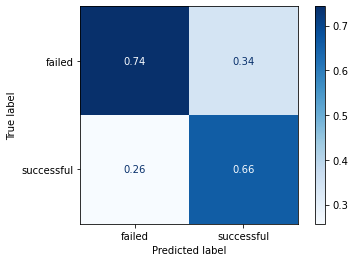

In [45]:
plot_confusion_matrix(pipe, X_test, y_test, cmap=plt.cm.Blues, normalize='pred')

In [47]:
print(classification_report (y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

      failed       0.74      0.86      0.80     47039
  successful       0.66      0.49      0.56     27052

    accuracy                           0.72     74091
   macro avg       0.70      0.67      0.68     74091
weighted avg       0.71      0.72      0.71     74091



In [49]:
# Here we convert successful / unsuccessful to 1/0 respectively

from sklearn.metrics import f1_score
y_true = np.where(y_test == 'successful', 1, 0)
y_pred = np.where(pipe.predict(X_test) == 'successful', 1, 0)
# our f1 score
f1_score(y_true, y_pred)

# Matches our score above in the table.

0.5587684183630014

In [51]:
(0.66*0.49)/(0.66+0.49)*2

0.5624347826086957

In [52]:
pipe[1].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

`'scale_pos_weight': 1,' is a really important parameter.`  

It looks at how much weight we give the positive class vs the negative class. It changes how much error that we contribute to this specifc sample.

In [53]:
pipe.predict_proba(X)[:,1]

array([0.1935314 , 0.16697004, 0.17481238, ..., 0.88779676, 0.43775547,
       0.97025573], dtype=float32)

In [54]:
np.where(y=='successful',1,0)

array([0, 0, 0, ..., 1, 0, 1])

In [56]:
# Our error column
np.where(y=='successful',1,0) - pipe.predict_proba(X)[:,1]

array([-0.19353139, -0.16697004, -0.17481238, ...,  0.11220324,
       -0.43775547,  0.02974427])

In [57]:
y.value_counts()
# So in this case, we'd adjust our scale positiverate to 3.

failed        236498
successful    133956
Name: state, dtype: int64

In [58]:
133956 / (133956+236498)

0.36159955082142453

In [59]:
weight_values = [1, 2, 3, 4]
cv_scores  = []
for weight in weight_values:
    print(f"Testing the validation score for weighting of: {weight}")
    pipe.steps[1][1].set_params(scale_pos_weight=weight)
    pipe.fit(X_train, y_train)
    y_true = np.where(y_test == 'successful', 1, 0)
    y_pred = np.where(pipe.predict(X_test) == 'successful', 1, 0)
    val_score = f1_score(y_true, y_pred)
    print(f"Validation score: {val_score}")
    cv_scores.append((val_score, weight))
top_score = max(cv_scores)
pipe.steps[1][1].set_params(scale_pos_weight=top_score[1])

Testing the validation score for weighting of: 1


/usr/local/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:08:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation score: 0.5317519891908122
Testing the validation score for weighting of: 2
[13:08:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation score: 0.6212966673860099
Testing the validation score for weighting of: 3
[13:08:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Testing the validation score for weighting of: 1

Validation score: 0.5317519891908122  

***
Testing the validation score for weighting of: 2

Validation score: 0.6212966673860099  

***
Testing the validation score for weighting of: 3  

Validation score: 0.6171895737113128  

***
Testing the validation score for weighting of: 4  

Validation score: 0.6064959783876711  

